## Summary of Work

As a passionate Boston Celtics fan, I have always been curious about the factors that contribute to a team's success in basketball. The Celtics are ranked #1 in the Eastern Conference as of early 2023, and most nights, they play with exactly the type of outstanding performance Boston sports fans come to expect from them. However, there are other nights where it's like watching a completely different and disjointed team on the court. What factors impact a team's performance on the court fromg game to game? With the help of box score data sourced from NBA.com and machine learning algorithms, I am setting out to build a model that can identify the most important factors and use them to accurately predict the outcome of NBA games. 

The National Basketball Association (NBA) was founded in 1946, making it one of the oldest professional sports leagues in North America. Over the years, the league has grown in size and popularity, and today it features 30 teams from across the United States and Canada. My research ino the NBA as well as my observations from being a fan have revealed that factors such as home-court advantage, number of rest days, and previous team performance can have predictive power in determining the outcome of a game.

Some argue that the outcome of basketball is relatively easy to predict compared to other sports. The main argument is that basketball is a high-scoring sport, with teams scoring over 100 points per game on a regular basis. Thus, basketball is subject to less randomness than low-scoring sports like soccer or baseball, in which luck may play a larger role. Many NBA teams also feature star players who have a significant impact on the outcome of the game, which can make it easier to predict the winner based on the performance of those players. However, even the best teams and players have nights where they perform worse than expected, and factors that are harder to measure such as team chemistry and coaching strategy can play a significant role in determining the outcome of a game. At the end of the day, NBA players are humans subject to randomness in health, attitude, and performance game-to-game, which can make basketball outcomes tricky to predict.

Many websites and experts have attempted to predict NBA game outcomes with varying degrees of success. One notable example is FiveThirtyEight, which has built a reputation for using data and statistics to make predictions in various fields, including politics and sports. I will be using some of the methodology from FiveThirtyEight's ELO model in my analysis. The ELO Rating system was not founded by FiveThirtyEight, rather it was invented and used much earlier for predicting chess outcomes and later adapted to professional sports leagues such as the NBA and NFL. 

The ELO Rating system measures a team's relative strength throughout a season. Each team begins their first game (in my dataset, this would be the first game of the 2017-2018 season) with an ELO rating of 1500. After each game, the two teams who participated in the game exchange a certain number of points based on factors such as the winner, the margin of victory, and home court advantage, with more points being awarded for upsets where the underdog won the game.

After the season is over, teams do not have a "hard reset" back to 1500 points for the beginning of the next season; rather they revert to the mean in a "soft reset". The Elo rating for the start of the next season is calculated as 75% of the team's Elo rating at the end of the previous season, plus 25% of the original Elo rating of 1500. The reason that the soft reset is desirable here is to account for the fact that not all teams are created equal, and good teams tend to stay good from season-to-season while bad teams tend to stay bad. Take the Golden State Warriors, for example, who pay a large amount of what is called 'luxury tax' to keep expensive players on their roster. Of course, factors such as trades in the offseason, player skill change, and new coaching can have a big impact on team performance, but to assume that all teams revert to being equal every season would be grossly incorrect.

## Importing Data from NBA_API

For this analysis, I will be using data sourced from NBA.com through NBA_API, which is a free and open-source API available through Python. The API code and methodology is available here: https://github.com/swar/nba_api

In [628]:
import pandas as pd 
import numpy as np
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

# Importing all NBA games

from nba_api.stats.endpoints import leaguegamefinder
gamefinder = leaguegamefinder.LeagueGameFinder(league_id_nullable="00")
league_games = gamefinder.get_data_frames()[0]

league_games = league_games[league_games['SEASON_ID'].isin(['22022', '22021', '22020', '22019', '22018', '22017', '22016', '22015', '22014'])]

league_games[['SEASON_ID', 'GAME_ID', 'TEAM_ID']] = league_games[['SEASON_ID', 'GAME_ID', 'TEAM_ID']].astype(str)

display(league_games)
league_games.to_csv('/Users/kaileighstopa/Desktop/Python Practice/Celtics Project/league_games.csv')

seasons = ['22022', '22021', '22020', '22019', '22018', '22017', '22016', '22015', '22014']

# from nba_api.stats.endpoints import boxscoretraditionalv2
# import time

# league_box_scores = pd.DataFrame()
# for season in seasons:
#     season  = league_games[league_games['SEASON_ID'] == season]
#     display(season)
#     season_game_ids = season['GAME_ID'].unique()
#     display(len(season_game_ids))
#     for game_id in season_game_ids:
#         league_box_score = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game_id, timeout=200000)
#         league_box_score = league_box_score.get_data_frames()[0]
#         league_box_scores = pd.concat([league_box_scores, league_box_score], axis=0)
#         time.sleep(1)

# display(league_box_scores.head())

# league_box_scores.to_csv('/Users/kaileighstopa/Desktop/Python Practice/Celtics Project/league_box_scores.csv')

league_games = pd.read_csv('/Users/kaileighstopa/Desktop/Python Practice/Celtics Project/league_games.csv')
league_box_scores = pd.read_csv('/Users/kaileighstopa/Desktop/Python Practice/Celtics Project/league_box_scores.csv')

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22022,1610612748,MIA,Miami Heat,0022200974,2023-03-06,MIA vs. ATL,W,241,130,...,0.865,8,24,32,27,6,4,11,17,2.0
1,22022,1610612740,NOP,New Orleans Pelicans,0022200976,2023-03-06,NOP @ SAC,L,239,108,...,0.786,7,33,40,29,6,4,16,19,-15.0
2,22022,1610612765,DET,Detroit Pistons,0022200977,2023-03-06,DET vs. POR,L,241,104,...,0.700,16,36,52,30,9,6,16,21,-6.0
3,22022,1610612755,PHI,Philadelphia 76ers,0022200972,2023-03-06,PHI @ IND,W,241,147,...,0.921,5,31,36,37,6,5,11,26,4.0
4,22022,1610612739,CLE,Cleveland Cavaliers,0022200971,2023-03-06,CLE vs. BOS,W,265,118,...,0.800,16,42,58,27,4,7,15,20,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,22014,1610612759,SAS,San Antonio Spurs,0021400002,2014-10-28,SAS vs. DAL,W,241,101,...,0.813,9,29,38,23,5,3,20,20,1.0
23730,22014,1610612745,HOU,Houston Rockets,0021400003,2014-10-28,HOU @ LAL,W,241,108,...,0.680,14,33,47,22,7,3,13,30,18.0
23731,22014,1610612742,DAL,Dallas Mavericks,0021400002,2014-10-28,DAL @ SAS,L,239,100,...,0.842,9,24,33,17,9,3,10,20,-1.0
23732,22014,1610612753,ORL,Orlando Magic,0021400001,2014-10-28,ORL @ NOP,L,239,84,...,0.762,16,40,56,17,5,9,18,25,-17.0


In [629]:
# We will use league_games for the prelim model

# Drop league_games columns where season does not begin with a '2' for regular season
league_games[['SEASON_ID', 'GAME_ID', 'TEAM_ID']] = league_games[['SEASON_ID', 'GAME_ID', 'TEAM_ID']].astype(str)
seasons = ['22022', '22021', '22020', '22019', '22018', '22017', '22016', '22015', '22014']
mask = league_games['SEASON_ID'].isin(seasons)
league_games = league_games[mask]

# Counting games by season
game_count = league_games.groupby(['SEASON_ID', 'TEAM_NAME']).size()
display(game_count)


SEASON_ID  TEAM_NAME         
22014      Atlanta Hawks         82
           Boston Celtics        82
           Brooklyn Nets         82
           Charlotte Hornets     82
           Chicago Bulls         82
                                 ..
22022      Sacramento Kings      64
           San Antonio Spurs     65
           Toronto Raptors       66
           Utah Jazz             65
           Washington Wizards    64
Length: 270, dtype: int64

In [630]:
display(league_games.isna().sum())

Unnamed: 0           0
SEASON_ID            0
TEAM_ID              0
TEAM_ABBREVIATION    0
TEAM_NAME            0
GAME_ID              0
GAME_DATE            0
MATCHUP              0
WL                   0
MIN                  0
PTS                  0
FGM                  0
FGA                  0
FG_PCT               0
FG3M                 0
FG3A                 0
FG3_PCT              0
FTM                  0
FTA                  0
FT_PCT               0
OREB                 0
DREB                 0
REB                  0
AST                  0
STL                  0
BLK                  0
TOV                  0
PF                   0
PLUS_MINUS           0
dtype: int64

Feature engineering

In [631]:
# Creating win_lose_margin feature
game_ids = league_games['GAME_ID'].unique()

## i think win-lose margin can't be used as a feature as it is for the current game
# Loop through each game ID and team combination
for game_id in game_ids:
    for team_id in league_games.loc[league_games['GAME_ID']==game_id, 'TEAM_ID'].unique():
        team_pts = league_games.loc[(league_games['GAME_ID']==game_id) & (league_games['TEAM_ID']==team_id), 'PTS'].iloc[0]
        opponent_pts = league_games.loc[(league_games['GAME_ID']==game_id) & (league_games['TEAM_ID']!=team_id), 'PTS'].iloc[0]
        
        # Calculating win/lose margin for the current team
        win_lose_margin = team_pts - opponent_pts
        
        # Assigning win/lose margin to the current row for the current team
        league_games.loc[(league_games['GAME_ID']==game_id) & (league_games['TEAM_ID']==team_id), 'win_lose_margin'] = win_lose_margin     

# Creating home/away feature
league_games['home'] = league_games['MATCHUP'].str.contains('vs.').astype(int)

# Creating win binary feature
league_games['win'] = league_games['WL'] == 'W'

# Creating matchup IDs
league_games['home_team_abv'] = league_games['MATCHUP'].str[-3:]
league_games['away_team_abv'] = league_games['MATCHUP'].str[:3]
league_games['matchup_id'] = league_games.apply(lambda row: '-'.join(sorted([row['home_team_abv'], row['away_team_abv']])), axis=1)
league_games = league_games.sort_values('GAME_DATE')


league_games['three_matchup_win_pct' ] = league_games.groupby(['matchup_id', 'TEAM_ID'])['win'].apply(lambda x: x.rolling(3, min_periods=3).mean().shift(1))

# Creating rest_days feature 
league_games['GAME_DATE'] = pd.to_datetime(league_games['GAME_DATE'])
league_games = league_games.sort_values(by='GAME_DATE')
team_games = league_games.groupby('TEAM_ID')
league_games['last_game_date'] = team_games['GAME_DATE'].shift(1)
league_games['rest_days'] = (league_games['GAME_DATE'] - league_games['last_game_date']).dt.days

# Imputing outliers/missing values for rest_days with the most common (mode) number of rest days in dataset
# Some games are an entire summer season apart so it doesn't make sense to leave them, and we can't model if the df has missing values
from scipy import stats
league_games.loc[((league_games['rest_days'].isna()) | (league_games['rest_days'] > 100)), 'rest_days'] = stats.mode(league_games['rest_days'], nan_policy='omit').mode[0]

# Drop 'last_game_date' feature
league_games = league_games.drop(columns='last_game_date')

/var/folders/1d/wshdc1vs5sldbdlstdtwvqbr0000gn/T/ipykernel_18350/1775792927.py:30: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  league_games['three_matchup_win_pct' ] = league_games.groupby(['matchup_id', 'TEAM_ID'])['win'].apply(lambda x: x.rolling(3, min_periods=3).mean().shift(1))
/var/folders/1d/wshdc1vs5sldbdlstdtwvqbr0000gn/T/ipykernel_18350/1775792927.py:42: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statisti

In [632]:
league_games = league_games.reset_index()

# Creating win_streak features to count how many games in a row a team has won
league_games['win_streak'] = 0 
current_streak = {}
current_results = {}

for i in range(len(league_games)):
    team_id = league_games.at[i, 'TEAM_ID']
    if team_id not in current_streak:
        current_streak[team_id] = 0
    if team_id not in current_results:
        current_results[team_id] = None
        
    if current_results[team_id] is not None and current_results[team_id] == True:
        current_streak[team_id] += 1
        league_games.at[i, 'win_streak'] = current_streak[team_id]
    else: 
        current_streak[team_id] = 0 
        league_games.at[i, 'win_streak'] = current_streak[team_id]
        
    current_results[team_id] = league_games['win'][i]



In [633]:
# Creating rolling averages for feature
rolling_features = ['MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'win_lose_margin', 
       'TEAM_ID', 'SEASON_ID', 'win']
rolling_df = league_games[rolling_features]

def find_team_averages(team):
    rolling = team.rolling(10).mean().shift(1)
    return rolling

rolling_df = rolling_df.groupby(['TEAM_ID', 'SEASON_ID'], group_keys=False).apply(find_team_averages)

rolling_cols = [f"{col}_MA" for col in rolling_df.columns]
rolling_df.columns = rolling_cols
league_games = pd.concat([league_games, rolling_df], axis=1)

league_games = league_games.drop(columns=['SEASON_ID_MA', 'TEAM_ID_MA'])

In [634]:
team_season_record = {}

for i in range(len(league_games)):
    team_id = league_games.at[i, 'TEAM_ID']
    season_id = league_games.at[i, 'SEASON_ID']
    game_date = league_games.at[i, 'GAME_DATE']
    
    if (team_id, season_id) not in team_season_record:
        team_season_record[(team_id, season_id)] = ({}, {})
    
    # Initialize win and loss records to 0 for the first game of the season
    if game_date == league_games.loc[(league_games['TEAM_ID'] == team_id) & (league_games['SEASON_ID'] == season_id), 'GAME_DATE'].min():
        win_record = 0
        loss_record = 0
    else:
        win_record, loss_record = team_season_record[(team_id, season_id)]
    
    # Calculate win and loss records for the current game
    league_games.at[i, 'win_record'] = win_record
    league_games.at[i, 'loss_record'] = loss_record

    if league_games.at[i, 'win'] == True:
        win_record += 1
    else:
        loss_record += 1
            
    team_season_record[(team_id, season_id)] = (win_record, loss_record)

# Creating a variable for win percentage
league_games['season_win_pct'] = league_games['win_record'] / (league_games['win_record'] + league_games['loss_record'])

league_games['season_win_pct'] = league_games['season_win_pct'].fillna('0')



In [635]:
league_games = league_games.sort_values(['SEASON_ID', 'GAME_DATE'])

In [636]:
league_games = league_games.sort_values(by=['GAME_DATE', 'TEAM_ID', 'SEASON_ID'])

# Initialize a dictionary to store the final ELO score for each team from the previous season
previous_season_elo = {}
elo_scores = {}

k_factor = 20 

# Loop through each unique season in the dataset
for season_id in league_games['SEASON_ID'].unique():
    
    # Initialize a dictionary to store the starting ELO score for each team in the current season
    starting_elo = {}
    
    # Loop through each unique team in the dataset
    for team_id in league_games['TEAM_ID'].unique():
        
        # If the team played in the previous season, use their final ELO score from the previous season as their starting ELO score
        if team_id in previous_season_elo:
            starting_elo[team_id] = (0.75 * previous_season_elo[team_id]) + (0.25 * 1500)
        
        # If the team did not play in the previous season, use the static 1500 value as their starting ELO score
        else:
            starting_elo[team_id] = 1500
    
    # Loop through each game in the current season and update the ELO scores for each team
    for game_id in league_games.loc[league_games['SEASON_ID'] == season_id, 'GAME_ID'].unique():
        for i, team_id in enumerate(league_games.loc[((league_games['SEASON_ID'] == season_id) & (league_games['GAME_ID'] == game_id)), 'TEAM_ID'].unique()):
            
            # Flag variable to indicate whether this is the first or second team in the game
            if i == 1:
                continue  # Skip the rest of the for loop for the second team 

            # If this is the first game of the season for the team, use their starting ELO score
            if league_games.loc[((league_games['SEASON_ID'] == season_id) & (league_games['TEAM_ID'] == team_id) & (league_games['GAME_ID'] == game_id)), 'GAME_DATE'].iloc[0] == \
                                league_games.loc[((league_games['SEASON_ID'] == season_id) & (league_games['TEAM_ID'] == team_id)), 'GAME_DATE'].min():
                team_elo = starting_elo[team_id]
                league_games.loc[((league_games['SEASON_ID'] == season_id) & (league_games['GAME_ID'] == game_id) & (league_games['TEAM_ID'] == team_id)), 'elo'] = team_elo
            
            # Otherwise, use the ELO score from the previous game
            else:
                team_elo = elo_scores[team_id]
                league_games.loc[((league_games['SEASON_ID'] == season_id) & (league_games['GAME_ID'] == game_id) & (league_games['TEAM_ID'] == team_id)), 'elo'] = team_elo
            
            # Find the ID of the opponent team
            opponent_id = league_games.loc[((league_games['SEASON_ID'] == season_id) & (league_games['GAME_ID'] == game_id) & (league_games['TEAM_ID'] != team_id)), 'TEAM_ID'].iloc[0]
            
            # If this is the first game of the season for the opponent team, use their starting ELO score
            if league_games.loc[((league_games['SEASON_ID'] == season_id) & (league_games['TEAM_ID'] == opponent_id) & (league_games['GAME_ID'] == game_id)), 'GAME_DATE'].iloc[0] ==  \
                                league_games.loc[((league_games['SEASON_ID'] == season_id) & (league_games['TEAM_ID'] == opponent_id)), 'GAME_DATE'].min():
                opponent_elo = starting_elo[opponent_id]
                league_games.loc[((league_games['SEASON_ID'] == season_id) & (league_games['GAME_ID'] == game_id) & (league_games['TEAM_ID'] == opponent_id)), 'elo'] = opponent_elo

            # Otherwise, use the ELO score from the previous game
            else:
                opponent_elo = elo_scores[opponent_id]
                league_games.loc[((league_games['SEASON_ID'] == season_id) & (league_games['GAME_ID'] == game_id) & (league_games['TEAM_ID'] == opponent_id)), 'elo'] = opponent_elo

            # If team has home court advantage, add 100 to their elo score

            if league_games.loc[((league_games['SEASON_ID'] == season_id) & (league_games['TEAM_ID'] == team_id) & (league_games['GAME_ID'] == game_id)), 'home'].iloc[0] == 1: 
                team_elo_home = team_elo + 100 
            
            # Otherwise, add 100 to opponent elo score
            else:
                opponent_elo_home = opponent_elo + 100

            # Get number of points scored by each team in game_id
            team_points = league_games.loc[((league_games['SEASON_ID'] == season_id) & (league_games['TEAM_ID'] == team_id) & (league_games['GAME_ID'] == game_id)), 'PTS'].iloc[0]
            opponent_points = league_games.loc[((league_games['SEASON_ID'] == season_id) & (league_games['TEAM_ID'] != team_id) & (league_games['GAME_ID'] == game_id)), 'PTS'].iloc[0]

            # Calculate the expected win probability for each team, taking into account whether they are home or away

            # If team won
            if league_games.loc[(league_games['SEASON_ID'] == season_id) & (league_games['GAME_ID'] == game_id) & (league_games['TEAM_ID'] == team_id), 'win'].iloc[0] == True:
                
                # If team won and is home
                if league_games.loc[((league_games['SEASON_ID'] == season_id) & (league_games['TEAM_ID'] == team_id) & (league_games['GAME_ID'] == game_id)), 'home'].iloc[0] == 1: 
                    team_win_prob =  1 / (1 + 10**((opponent_elo - team_elo_home) / 400))
                    mov_multiplier = ((team_points-opponent_points)**(0.8))/(7.5 + (.006 * (team_elo_home - opponent_elo)))
                    elo_scores[team_id] = team_elo + (k_factor * (1 - team_win_prob) * mov_multiplier)
                    elo_scores[opponent_id] = opponent_elo - (k_factor * (1 - team_win_prob) * mov_multiplier)
                # If team won and is away 
                else:
                    team_win_prob =  1 / (1 + 10**((opponent_elo_home - team_elo) / 400))
                    mov_multiplier = ((team_points-opponent_points)**(0.8))/(7.5 + (.006 * (team_elo - opponent_elo_home)))
                    elo_scores[team_id] = team_elo + (k_factor * (1 - team_win_prob) * mov_multiplier)
                    elo_scores[opponent_id] = opponent_elo - (k_factor * (1 - team_win_prob) * mov_multiplier)

            # If opponent won
            else: 

                # If opponent won and is home
                if league_games.loc[((league_games['SEASON_ID'] == season_id) & (league_games['TEAM_ID'] == opponent_id) & (league_games['GAME_ID'] == game_id)), 'home'].iloc[0] == 1: 
                    opponent_win_prob = 1 / (1 + 10**((team_elo - opponent_elo_home) / 400))
                    mov_multiplier = ((opponent_points-team_points)**(0.8))/(7.5 + (.006 * (opponent_elo_home - team_elo)))
                    elo_scores[opponent_id] = opponent_elo + (k_factor * (1 - opponent_win_prob) * mov_multiplier)
                    elo_scores[team_id] = team_elo - (k_factor * (1 - opponent_win_prob) * mov_multiplier)
                # If opponent won and is away
                else: 
                    opponent_win_prob = 1 / (1 + 10**((team_elo_home - opponent_elo) / 400))
                    mov_multiplier = ((opponent_points-team_points)**(0.8))/(7.5 + (.006 * (opponent_elo - team_elo_home)))
                    elo_scores[opponent_id] = opponent_elo + (k_factor * (1 - opponent_win_prob) * mov_multiplier)
                    elo_scores[team_id] = team_elo - (k_factor * (1 - opponent_win_prob) * mov_multiplier)
            
            # If this is the last game of the season for the team, set previous_season_elo = team_elo
            if league_games.loc[((league_games['SEASON_ID'] == season_id) & (league_games['TEAM_ID'] == team_id) & (league_games['GAME_ID'] == game_id)), 'GAME_DATE'].iloc[0] == \
                                league_games.loc[((league_games['SEASON_ID'] == season_id) & (league_games['TEAM_ID'] == team_id)), 'GAME_DATE'].max():
                previous_season_elo[team_id] = elo_scores[team_id]

            # If this is the last game of the season for the opponent, set previous_season_elo = opponent_elo           
            if league_games.loc[((league_games['SEASON_ID'] == season_id) & (league_games['TEAM_ID'] == opponent_id) & (league_games['GAME_ID'] == game_id)), 'GAME_DATE'].iloc[0] == \
                                league_games.loc[((league_games['SEASON_ID'] == season_id) & (league_games['TEAM_ID'] == opponent_id)), 'GAME_DATE'].max():
                previous_season_elo[opponent_id] = elo_scores[opponent_id]


In [637]:
# Putting opponent features into columns
league_games_opp = league_games.copy()
league_games_opp.columns = [f"{col}_opp" if col not in ["GAME_ID", "TEAM_ID"] else col for col in league_games.columns]

# Merge the two dataframes on the 'GAME_ID' column and opposite team IDs
merged_df = pd.merge(league_games, league_games_opp, on=['GAME_ID'], suffixes=['', '_opp'], how='outer')
merged_df = merged_df[merged_df['TEAM_ID'] != merged_df['TEAM_ID_opp']]  

In [638]:
# Cleaning up columns a bit
merged_df = merged_df.drop(columns=['index', 'Unnamed: 0', 'WL', 'index_opp', 'Unnamed: 0_opp', 'SEASON_ID_opp', 'GAME_DATE_opp', 'MATCHUP_opp', 'WL_opp'])

In [639]:
display(merged_df.columns.values)

display(len(merged_df))

display(merged_df.isna().sum())

merged_df = merged_df.dropna()
display(len(merged_df))

array(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME',
       'GAME_ID', 'GAME_DATE', 'MATCHUP', 'MIN', 'PTS', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PLUS_MINUS', 'win_lose_margin', 'home', 'win', 'home_team_abv',
       'away_team_abv', 'matchup_id', 'three_matchup_win_pct',
       'rest_days', 'win_streak', 'MIN_MA', 'PTS_MA', 'FGM_MA', 'FGA_MA',
       'FG_PCT_MA', 'FG3M_MA', 'FG3A_MA', 'FG3_PCT_MA', 'FTM_MA',
       'FTA_MA', 'FT_PCT_MA', 'OREB_MA', 'DREB_MA', 'REB_MA', 'AST_MA',
       'STL_MA', 'BLK_MA', 'TOV_MA', 'PF_MA', 'PLUS_MINUS_MA',
       'win_lose_margin_MA', 'win_MA', 'win_record', 'loss_record',
       'season_win_pct', 'elo', 'TEAM_ID_opp', 'TEAM_ABBREVIATION_opp',
       'TEAM_NAME_opp', 'MIN_opp', 'PTS_opp', 'FGM_opp', 'FGA_opp',
       'FG_PCT_opp', 'FG3M_opp', 'FG3A_opp', 'FG3_PCT_opp', 'FTM_opp',
       'FTA_opp', 'FT_PCT_opp', 'OREB_opp', 

20990

SEASON_ID                0
TEAM_ID                  0
TEAM_ABBREVIATION        0
TEAM_NAME                0
GAME_ID                  0
                      ... 
win_MA_opp            2700
win_record_opp           0
loss_record_opp          0
season_win_pct_opp       0
elo_opp                  0
Length: 120, dtype: int64

15988

In [671]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeClassifier

rr = RidgeClassifier(alpha=1)
split = TimeSeriesSplit(n_splits=3)
sfs = SequentialFeatureSelector(rr, n_features_to_select=30, direction="forward", cv=split) 

removed_columns = ['index', 'home_team_abv_opp', 'away_team_abv_opp', 'home_team_abv', 'away_team_abv',
       'matchup_id_opp', 'matchup_id', 'SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME',
       'GAME_ID', 'GAME_DATE', 'MATCHUP', 'MIN', 'PTS', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PLUS_MINUS', 'win', 'TEAM_ID_opp', 'TEAM_ABBREVIATION_opp', 
       'TEAM_NAME_opp', 'MIN_opp','PTS_opp', 'FGM_opp', 'FGA_opp', 'FG_PCT_opp', 
       'FG3M_opp', 'FG3A_opp', 'FG3_PCT_opp', 'FTM_opp', 'FTA_opp', 'FT_PCT_opp',
       'OREB_opp', 'DREB_opp', 'REB_opp', 'AST_opp', 'STL_opp', 'BLK_opp',
       'TOV_opp', 'PF_opp', 'PLUS_MINUS_opp', 'home_opp', 'win_opp', 'win_lose_margin', 'win_lose_margin_opp'] 

selected_columns = merged_df.columns[~merged_df.columns.isin(removed_columns)]

from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()
merged_df[selected_columns] = scaler.fit_transform(merged_df[selected_columns])

sfs.fit(merged_df[selected_columns], merged_df['win'])

# get list of predictor columns out of sequential feature selection
predictors = list(selected_columns[sfs.get_support()])

display(predictors)

['home',
 'rest_days',
 'win_streak',
 'MIN_MA',
 'FGM_MA',
 'FG_PCT_MA',
 'FG3A_MA',
 'FTM_MA',
 'OREB_MA',
 'AST_MA',
 'PLUS_MINUS_MA',
 'win_record',
 'loss_record',
 'elo',
 'three_matchup_win_pct_opp',
 'rest_days_opp',
 'MIN_MA_opp',
 'PTS_MA_opp',
 'FGA_MA_opp',
 'FG3M_MA_opp',
 'FG3A_MA_opp',
 'FTM_MA_opp',
 'OREB_MA_opp',
 'REB_MA_opp',
 'AST_MA_opp',
 'STL_MA_opp',
 'win_lose_margin_MA_opp',
 'win_MA_opp',
 'loss_record_opp',
 'season_win_pct_opp']

In [649]:
display(merged_df.groupby('SEASON_ID')['GAME_DATE'].nunique())

SEASON_ID
22014     50
22015    141
22016    142
22017    148
22018    147
22019    129
22020    122
22021    145
22022    111
Name: GAME_DATE, dtype: int64

In [672]:
#backtest 
def backtest(data, model, predictors, start=2, step=1):
    all_predictions = []
    seasons = sorted(merged_df["SEASON_ID"].unique())
    for i in range(start, len(seasons), step):
        season = seasons[i]
        train = data[data["SEASON_ID"] < season]
        test = data[data["SEASON_ID"] == season]
        model.fit(train[predictors], train["win"])
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test["win"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        all_predictions.append(combined)
    return pd.concat(all_predictions)

predictions = backtest(merged_df, rr, predictors)

from sklearn.metrics import accuracy_score

accuracy_score(predictions["actual"], predictions["prediction"])


from sklearn.model_selection import TimeSeriesSplit, cross_val_score

tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(rr, merged_df[predictors], merged_df['win'], cv=tscv, scoring='accuracy')
print('Cross-validation scores: ', scores)
print('Mean cross-validation score: ', scores.mean())

Cross-validation scores:  [0.64114114 0.66966967 0.65878378 0.63738739 0.64902402]
Mean cross-validation score:  0.6512012012012012


Ridge Regression Mean Cross-Validation Accuracy Score: 0.6515015015015015
KNN Mean Cross-Validation Accuracy Score: 0.5981231231231232
Support Vector Classifier Mean Cross-Validation Accuracy Score: 0.6444444444444445
Gradient Boosting Mean Cross-Validation Accuracy Score: 0.6491741741741741
Bagging Classifier Mean Cross-Validation Accuracy Score: 0.6079579579579579
Random Forest Classifier Mean Cross-Validation Accuracy Score: 0.6423423423423424
Decision Tree Classifer Mean Cross-Validation Accuracy Score: 0.5640390390390391
Logistic Regression Mean Cross-Validation Accuracy Score: 0.6506006006006005
XGB Classifier Mean Cross-Validation Accuracy Score: 0.616891891891892


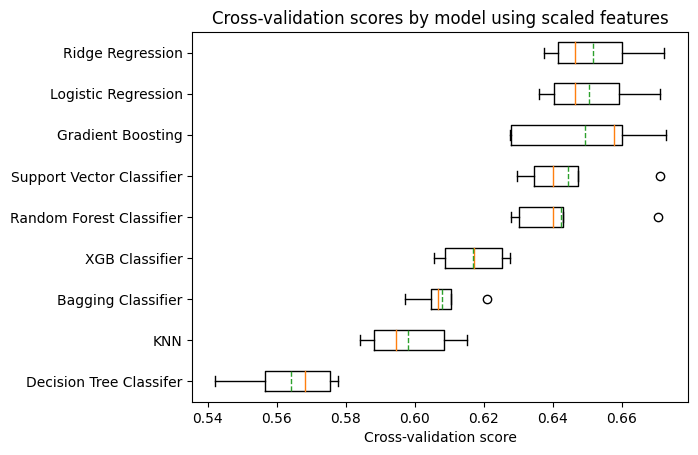

Ridge Regression Test Set Accuracy: 0.6508999280057596
KNN Test Set Accuracy: 0.5922966162706983
Support Vector Classifier Test Set Accuracy: 0.6452123830093592
Gradient Boosting Test Set Accuracy: 0.645572354211663
Bagging Classifier Test Set Accuracy: 0.6029517638588913
Random Forest Classifier Test Set Accuracy: 0.6327573794096473
Decision Tree Classifer Test Set Accuracy: 0.5597552195824333
Logistic Regression Test Set Accuracy: 0.6511159107271418
XGB Classifier Test Set Accuracy: 0.6131749460043197


In [655]:
# Import necessary libraries for building models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Testing multiple models on scaled features
np.random.seed(41)
models ={"Ridge Regression": RidgeClassifier(alpha=1, random_state=41), "KNN": KNeighborsClassifier(), 
         "Support Vector Classifier": SVC(random_state=41), "Gradient Boosting": GradientBoostingClassifier(random_state=41),
	     "Bagging Classifier": BaggingClassifier(random_state=41), "Random Forest Classifier": RandomForestClassifier(random_state=41),
         "Decision Tree Classifer": DecisionTreeClassifier(random_state=41), "Logistic Regression": LogisticRegression(random_state=41, max_iter=2000),
         "XGB Classifier": XGBClassifier(random_state=41)}
results = []
for name, model in models.items():
	tscv = TimeSeriesSplit(n_splits=5)
	cv_results = cross_val_score(model, merged_df[predictors], merged_df['win'], cv=tscv, scoring='accuracy') 
	results.append(cv_results)
	print("{} Mean Cross-Validation Accuracy Score: {}".format(name, cv_results.mean()))
	
# Sort the models by the mean cross-validation accuracy score
sorted_results = sorted(zip(models.keys(), results), key=lambda x: x[1].mean(), reverse=False)
labels = [model[0] for model in sorted_results]
results = [model[1] for model in sorted_results]

plt.boxplot(results, labels=labels, meanline=True, showmeans=True, vert=False)
plt.title('Cross-validation scores by model using scaled features')
plt.xlabel('Cross-validation score')
plt.show()

# Model performance on test set
for name, model in models.items(): 
	model.fit(merged_df[predictors], merged_df['win'])
	predictions = backtest(merged_df, model, predictors)
	score = accuracy_score(predictions["actual"], predictions["prediction"])
	print("{} Test Set Accuracy: {}".format(name, score))


In [ ]:
# Using GridSearchCV to find optimal alpha parameter
from sklearn.model_selection import GridSearchCV 

np.random.seed(41)
# Cross validation score 
tscv = TimeSeriesSplit(n_splits=5)
cv_results = cross_val_score(rr, merged_df[predictors], merged_df['win'], cv=tscv, scoring='accuracy') 
print("Ridge Regression mean CV score with default params:", cv_results.mean())

ridge_params = {
    "alpha": [0.001, 0.01, 0.1, 1, 5, 10],
}
ridge_cv = GridSearchCV(rr, ridge_params, cv=tscv, verbose=1, n_jobs=-1)
ridge_cv.fit(merged_df[predictors], merged_df['win'])
print(ridge_cv.best_params_)

# Fit gradient boosting regression model with best hyperparameters found through GridSearchCV
ridge_best = RidgeClassifier(alpha=ridge_cv.best_params_['alpha'])
ridge_best.fit(merged_df[predictors], merged_df['win'])
predictions = backtest(merged_df, ridge_best, predictors)
ridge_best_score = accuracy_score(predictions["actual"], predictions["prediction"])
ridge_best_cv = cross_val_score(ridge_best, merged_df[predictors], merged_df['win'], cv=tscv, scoring='accuracy')     
print("Ridge accuracy on test set with best params: {}".format(ridge_best_score))     
print("Ridge mean CV score using best hyperparameters: {}".format(ridge_best_cv.mean()))

Ridge Regression mean CV score with default params: 0.647408343868521
Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'alpha': 0.1}
Ridge accuracy on test set with best params: 0.643918918918919
Ridge mean CV score using best hyperparameters: 0.647661188369153


How does my model perform on predicting celtics games?

In [681]:
celtics = merged_df[(merged_df['home_team_abv'] == 'BOS') | (merged_df['away_team_abv'] == 'BOS')]

predictions = backtest(celtics, rr, predictors)

print(accuracy_score(predictions["actual"], predictions["prediction"]))

tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(rr, celtics[predictors], celtics['win'], cv=tscv, scoring='accuracy')
print('Cross-validation scores: ', scores)
print('Mean cross-validation score: ', scores.mean())


0.6156316916488223
Cross-validation scores:  [0.6424581  0.63687151 0.57541899 0.58659218 0.65921788]
Mean cross-validation score:  0.6201117318435754
